In [1]:
import os
#os.environ['OPENBLAS_NUM_THREADS'] = '1'

import pandas as pd

import scanpy as sc
import scanpy.external as sce
import anndata as ad

# Data retrieval
import pooch
import scanpy.external as sce
import matplotlib as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

sc.settings.set_figure_params(dpi=50, facecolor="white",figsize=(5, 5))

cmc_dir='/sc/arion/projects/CommonMind/roussp01a/ENT/snRNAseq/'


adata_ref = sc.read_h5ad(cmc_dir + 'qc_scanpy/NN.h5ad')



In [100]:
# # for each single sample
samples = adata_ref.obs['orig.ident'].unique()

adata_ref_split = []
for sample in samples:
    adata_ref_split.append(adata_ref[adata_ref.obs['orig.ident'] == sample].copy())

for adata_ref_sample in adata_ref_split:
    sc.pp.scrublet(adata_ref_sample)  

adata_ref_processed = ad.concat(adata_ref_split,join="outer",index_unique=None )



In [101]:
# change adata_ref.obs names to keep consistent with metadata
pd.DataFrame(adata_ref.obs.index)[0].str.split('-',expand=True)[0] 
a1 = pd.DataFrame(adata_ref.obs.index)[0].replace('-1','',regex=True)
a2 = a1.replace('patient','P',regex=True)
a3 = a2.str.split('_',expand=True)[1] + '-' + a2.str.split('_',expand=True)[0]

adata_ref.obs.index = a3

### # add cell annotation

In [102]:
# add cell annotation
meta = pd.read_csv(cmc_dir + 'qc_scanpy/NN.cell.annotations.patient.csv',index_col=0)
#adata_ref=adata_ref[a3.isin(meta.index)]
adata_ref_obs=adata_ref.obs
adata_ref_obs['id']= adata_ref.obs.index

adata_ref.obs=pd.merge(adata_ref_obs, meta, left_on= 'id',right_on='Barcode',how='left')
adata_ref.obs.index=adata_ref.obs['id']

ensg=pd.read_table('/sc/arion/projects/roussp01a/liting/Olf/Homo.GRCh38.104.txt',index_col=0)
chr_autos = [format(x, '1d') for x in range(1,23)]
ensg_pa = ensg.loc[(ensg.chr.isin(chr_autos)) & (ensg.gene_biotype=='protein_coding'),:]


/hpc/users/songl05/.conda/envs/Py39_R43_Ju10/lib/python3.9/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [103]:
meta= pd.read_table(cmc_dir + 'qc_scanpy/NN_clinical_metadata.txt',index_col=0 )

In [104]:
adata_ref.obs['Age']=meta.loc[adata_ref.obs['orig.ident'],'Age'].values
adata_ref.obs['Sex']=meta.loc[adata_ref.obs['orig.ident'],'Sex'].values

In [105]:
# adata.var_names_make_unique() 
# adata_ref.var_names_make_unique() 
adata_ref=adata_ref[~adata_ref.obs.CellType.isna()]


/hpc/users/songl05/.conda/envs/Py39_R43_Ju10/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/hpc/users/songl05/.conda/envs/Py39_R43_Ju10/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


### doublet_score

In [106]:
# # for each single sample
samples = adata_ref.obs['orig.ident'].unique()

adata_ref_split = []
for sample in samples:
    adata_ref_split.append(adata_ref[adata_ref.obs['orig.ident'] == sample].copy())

for adata_ref_sample in adata_ref_split:
    sc.pp.scrublet(adata_ref_sample)  

adata_ref_processed = ad.concat(adata_ref_split,join="outer",index_unique=None )

adata_ref=adata_ref_processed

In [107]:
sc.write(cmc_dir+'qc_scanpy/nn_cluster_merge.h5ad',adata_ref)

In [11]:
adata_ref = sc.read_h5ad(cmc_dir + 'qc_scanpy/nn_cluster_merge.h5ad')

N_adata= adata_ref[adata_ref.obs.CellType.isin(['Globose Basal Cells','Mature Neurons','Immature Neurons'])]


In [15]:
N_adata.obs.loc[:,['CellType','orig.ident']].value_counts()
#N_adata.obs.loc[:,['orig.ident']].value_counts()

CellType             orig.ident
Immature Neurons     patient2      257
Mature Neurons       patient2      200
Immature Neurons     patient3       99
Globose Basal Cells  patient2       49
                     patient4       31
Mature Neurons       patient3       22
Globose Basal Cells  patient1       18
                     patient3       17
Immature Neurons     patient1        1
dtype: int64

### Neurons

In [108]:
N_adata= adata_ref[adata_ref.obs.CellType.isin(['Globose Basal Cells','Mature Neurons','Immature Neurons'])]
N_adata= N_adata[N_adata.obs['orig.ident'].isin(['patient2','patient3'])]



/tmp/ipykernel_8546/3879651208.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  N_adata.layers["counts"] = N_adata.X.copy()
/hpc/users/songl05/.conda/envs/Py39_R43_Ju10/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


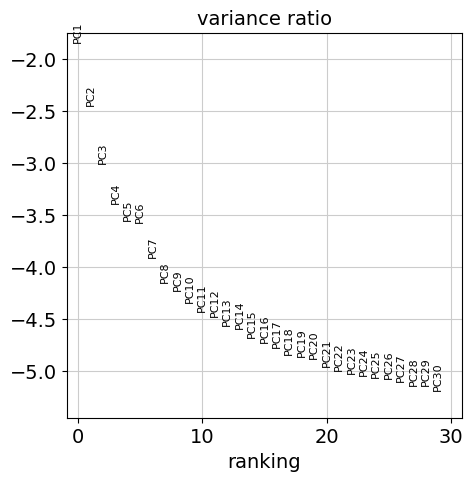

In [109]:
# scale
N_adata.layers["counts"] = N_adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(N_adata)
# Logarithmize the data
sc.pp.log1p(N_adata)

# highly_variable_genes
sc.pp.highly_variable_genes(N_adata, n_top_genes=500, batch_key = 'orig.ident')

N_adata.raw = N_adata # N_adata=N_adata.to_N_adata()

#N_adata = N_adata[:,N_adata.var.highly_variable]
# sc.pp.regress_out(N_adata, ["total_counts", "pct_counts_mt"])
# sc.pp.scale(N_adata, max_value=10)

sc.tl.pca(N_adata, use_highly_variable=True, n_comps=30)
sc.pl.pca_variance_ratio(N_adata, n_pcs=30, log=True)


In [110]:
N_adata.obs['orig.ident'].value_counts()

patient2    506
patient3    138
Name: orig.ident, dtype: int64

In [111]:

sce.pp.harmony_integrate(N_adata, 'orig.ident')
N_adata.obsm['X_pca'] = N_adata.obsm['X_pca_harmony']


2024-08-07 21:30:52,057 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-08-07 21:30:52,554 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-08-07 21:30:52,556 - harmonypy - INFO - Iteration 1 of 10
2024-08-07 21:30:52,596 - harmonypy - INFO - Iteration 2 of 10
2024-08-07 21:30:52,632 - harmonypy - INFO - Iteration 3 of 10
2024-08-07 21:30:52,659 - harmonypy - INFO - Iteration 4 of 10
2024-08-07 21:30:52,679 - harmonypy - INFO - Converged after 4 iterations


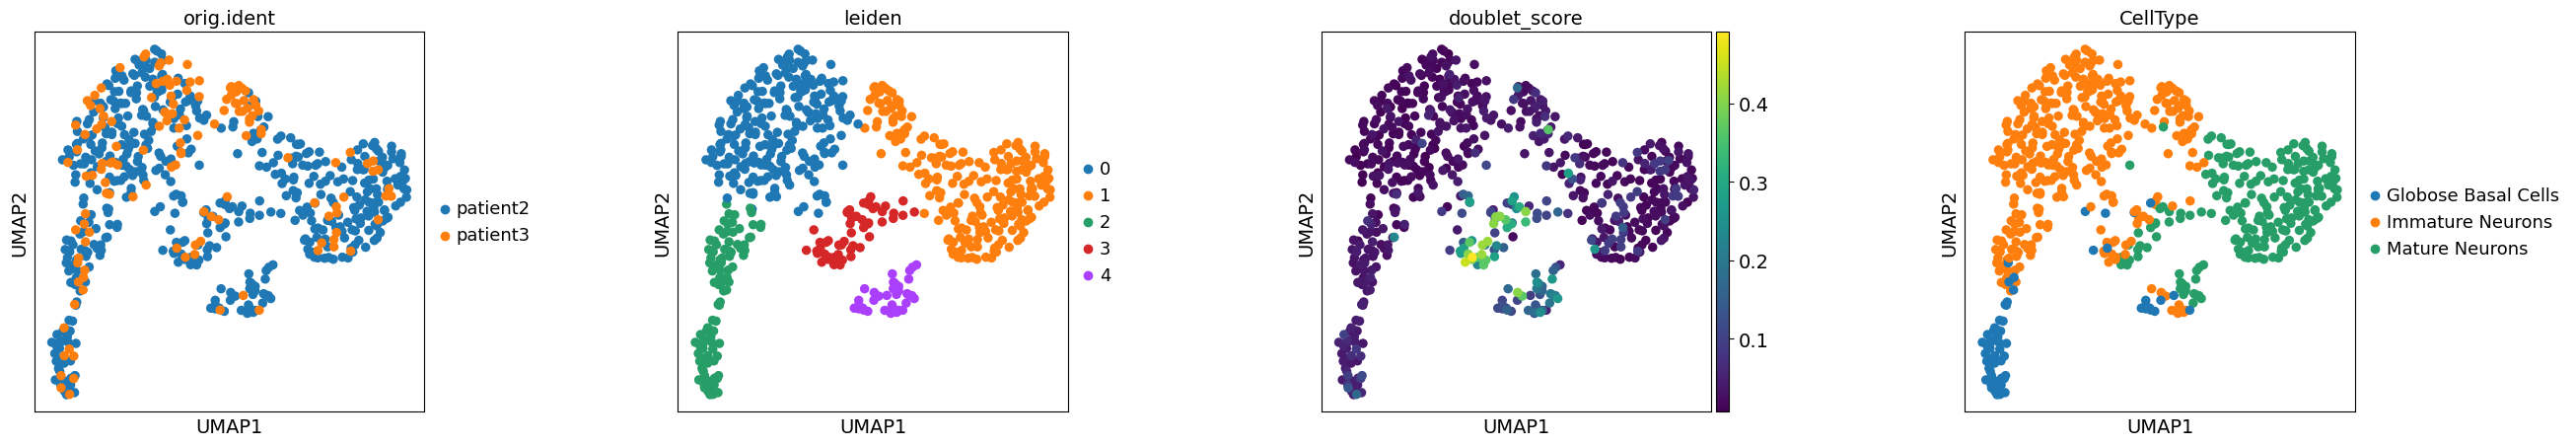

In [112]:
sc.pp.neighbors(N_adata, n_pcs=8,n_neighbors=30)
sc.tl.umap(N_adata)
sc.tl.leiden(N_adata, resolution=0.2)

sc.pl.umap(
    N_adata,
    color=['orig.ident','leiden','doublet_score', 'CellType'],
    # increase horizontal space between panels
    wspace=0.5,
    save='1_NN_Neuro_prefilt.pdf'  
)



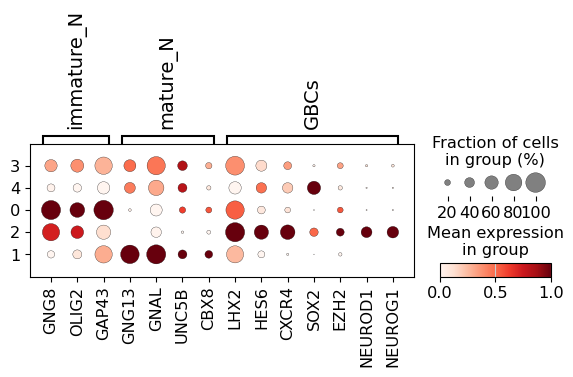

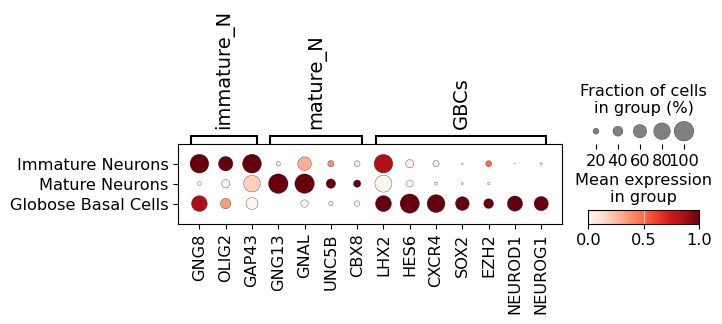

In [113]:
maker_genes_neuro = {"immature_N":["GNG8","OLIG2","GAP43"],
"mature_N":["GNG13",'GNAL',"UNC5B","CBX8"],
"GBCs":["LHX2","HES6","CXCR4","SOX2","EZH2","NEUROD1","NEUROG1"],}
sc.pl.dotplot(N_adata,  maker_genes_neuro, groupby="leiden", standard_scale="var")
sc.pl.dotplot(N_adata,  maker_genes_neuro, groupby="CellType", standard_scale="var")


In [114]:
N_adata_f=N_adata[N_adata.obs.leiden.isin(['0','1','2'])]


View of AnnData object with n_obs × n_vars = 553 × 25378
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'id', 'CellType', 'Age', 'Sex', 'doublet_score', 'predicted_doublet', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'orig.ident_colors', 'leiden_colors', 'CellType_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

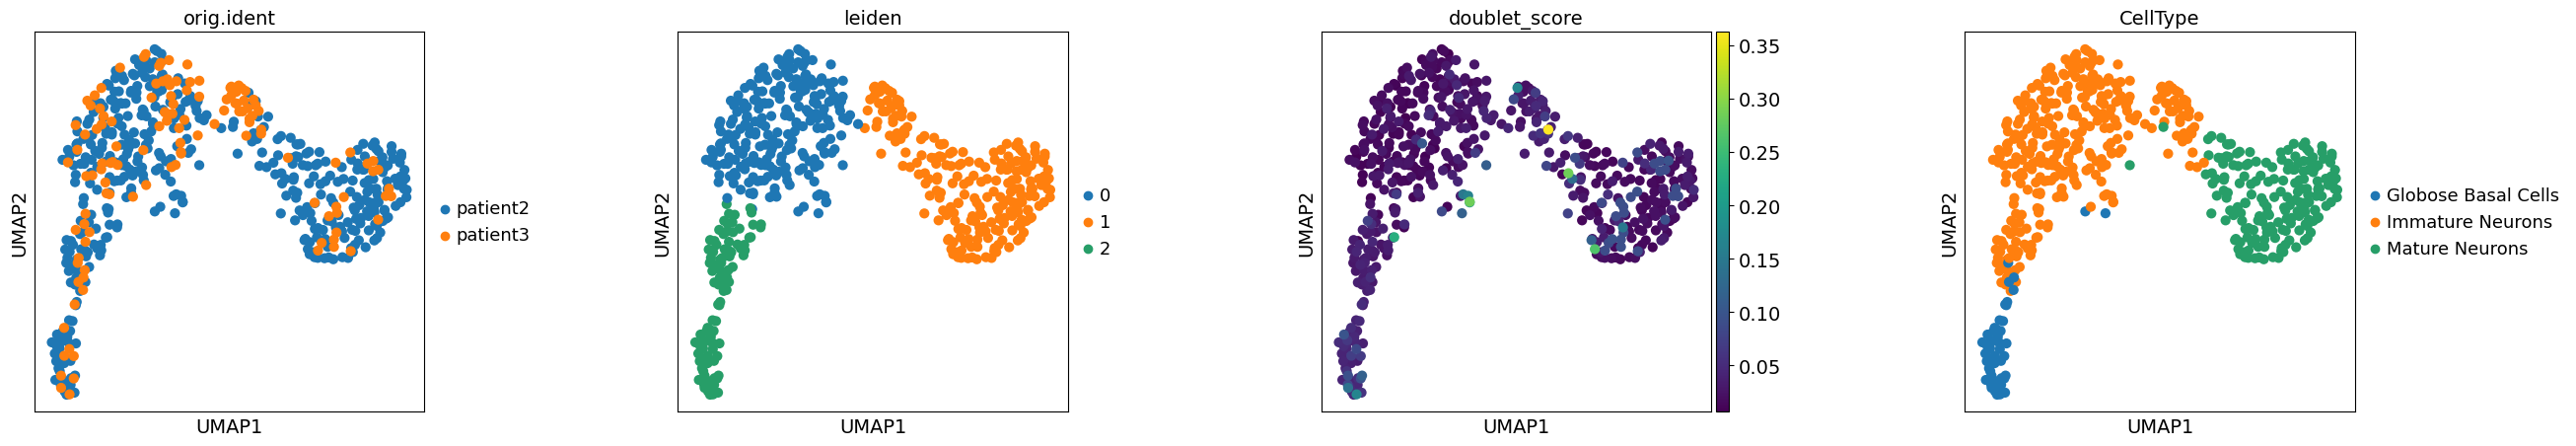

In [115]:
sc.pl.umap(
    N_adata_f,
    color=['orig.ident','leiden','doublet_score', 'CellType'],
    # increase horizontal space between panels
    wspace=0.5
)



In [121]:
new_cluster_names = {
    "Globose Basal Cells": "GBC",
    "Immature Neurons": "iOSN",
    "Mature Neurons": "mOSN",
}


N_adata_f.obs["N_types"] = N_adata_f.obs["CellType"].map(new_cluster_names)


iOSN    321
mOSN    182
GBC      50
Name: N_types, dtype: int64

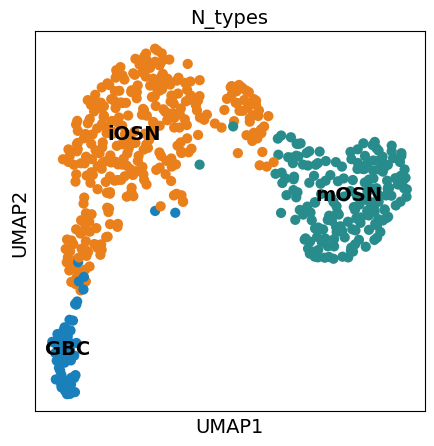

In [123]:


color_map = {
  "GBC":"#1a80bb",
  "iOSN":"#ea801c",
  "mOSN":"#298c8c",
 }


sc.pl.umap(
    N_adata_f,
    legend_loc='on data',
    color=['N_types'],
    # increase horizontal space between panels
    palette=color_map,
    wspace=0.5,
    save='1_NN_Neuro_types.pdf'  
)


GBCinp:


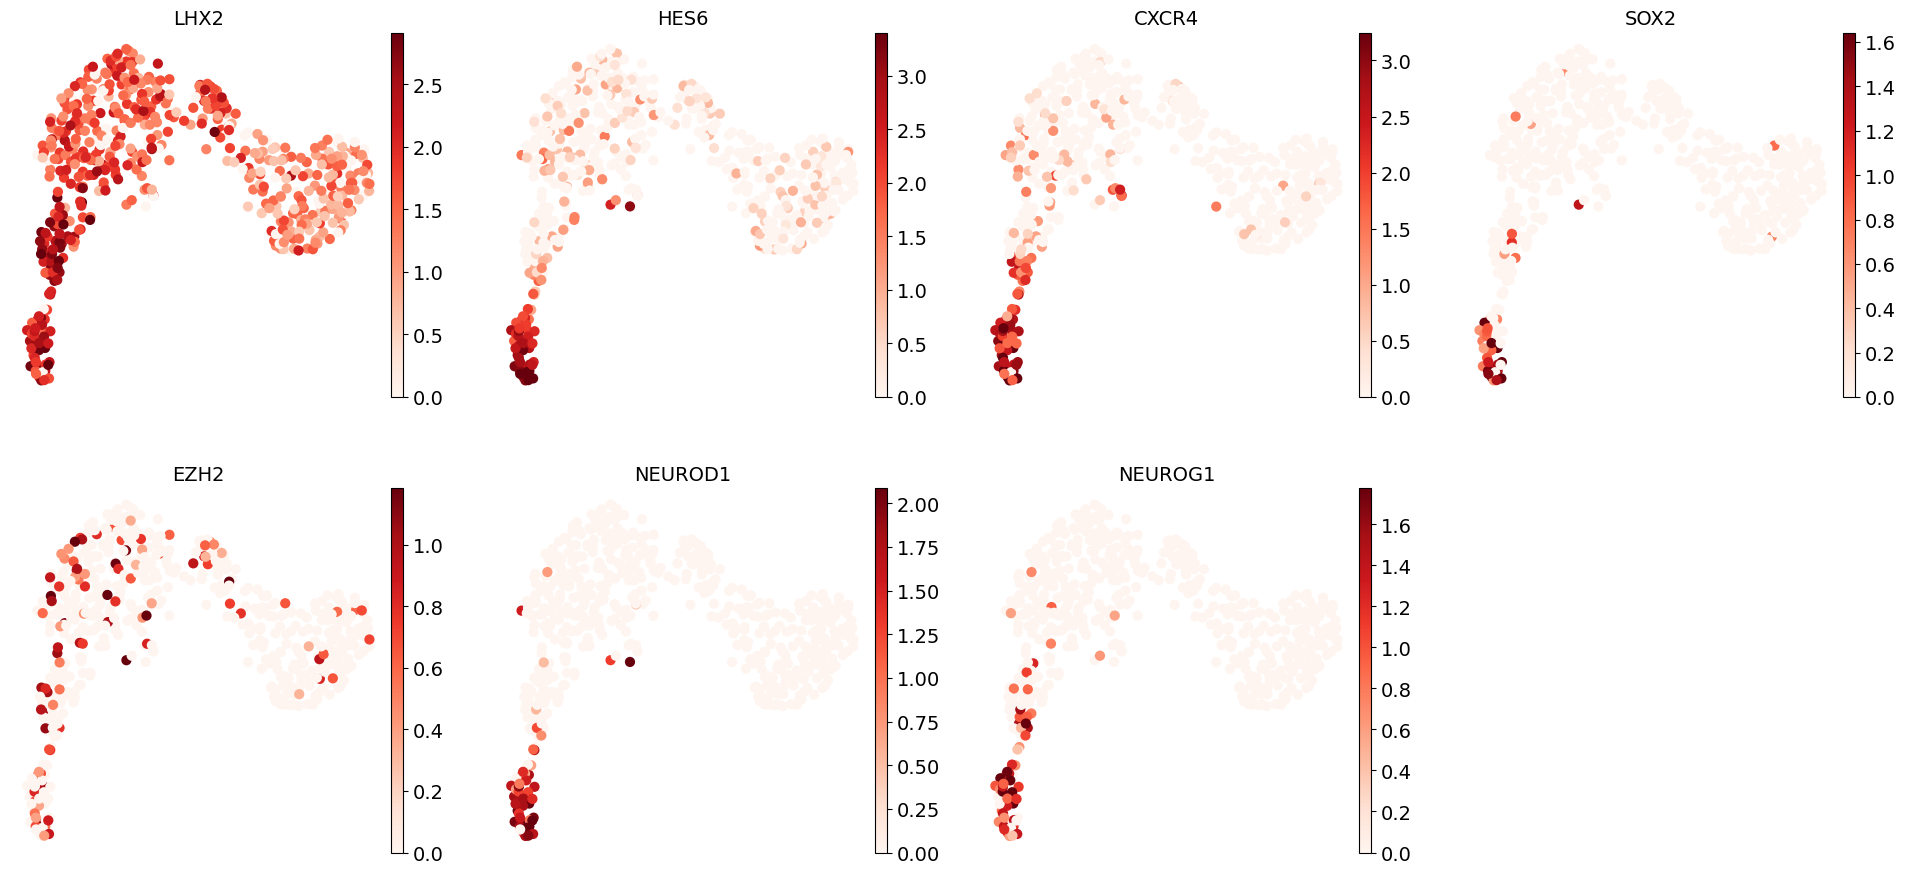

Immature Neurons:


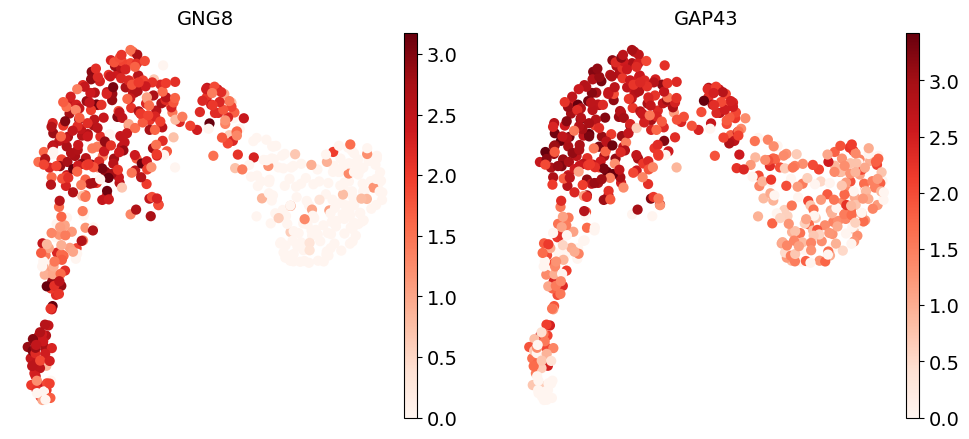

Mature Neurons:


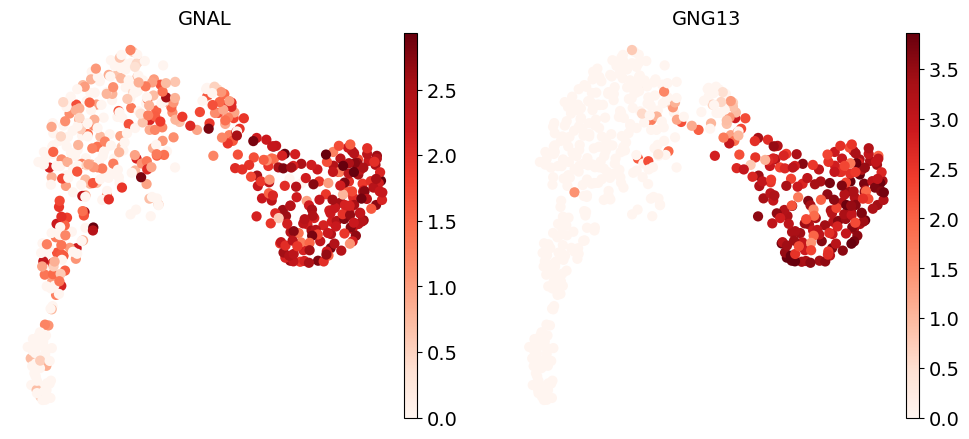

In [124]:
#sc.pp.highly_variable_genes(N_adata_f, n_top_genes=2000)

maker_genes_neuro = {
'GBCinp': ["LHX2","HES6","CXCR4","SOX2","EZH2","NEUROD1","NEUROG1"],
'Immature Neurons': ['GNG8', 'GAP43'],
'Mature Neurons': ['GNAL','GNG13'],#''
 }
N_cts = list(maker_genes_neuro.keys())
for ct in N_cts:
    print(f"{ct}:")
    sc.pl.umap(
        N_adata_f,
        legend_loc = None,
        color=maker_genes_neuro[ct],
        vmin=0,
        vmax="p99",  # set vmax to the 99th percentile of the gene count instead of the maximum, to prevent outliers from making expression in other cells invisible. Note that this can cause problems for extremely lowly expressed genes.
        sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
        frameon=False,
        cmap="Reds",  # or choose another color map e.g. from here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
    save='1_NN_Neuro_maker'+ct+ '.pdf'    
    )
    #print("\n\n\n")


In [125]:
cmc_dir='/sc/arion/projects/CommonMind/roussp01a/ENT/snRNAseq/'
sc.write(cmc_dir+"qc_scanpy/nn_N_clusters.h5ad", N_adata_f)


In [126]:

N_adata_Mf = adata_ref_processed[N_adata_f.obs.index]
N_adata_Mf.obs = N_adata_f.obs
#N_adata_Mf.uns = N_adata_f.uns
N_adata_Mf.obsm = N_adata_f.obsm
#N_adata_Mf.varm = N_adata_f.varm
sc.write(cmc_dir+"qc_scanpy/nn_N_clusters_rawcount.h5ad", N_adata_Mf)
